# Análise dos Descritores de Cor

Esse notebook tem como objetivo analisar alguns descritores de cor que irei utilizar como extratores de características. Foram utilizados os seguintes descritores:

<ul>
    <li><b>Histograma de Cor</b></li>
    <li><b>Espectro HSL para Detecção de Olhos Vermelhos</b></li>
    <li><b>Descritores de Cor Dominante</b></li>
    <li><b>Momentos de Cor</b></li>
</ul>
<hr>

##### Importação das bibliotecas necessárias

In [1]:
import numpy as np
import cv2

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis

Utilizaremos uma imagem de reflexo vermelho diagnósticada como <i>"Normal"</i> para realizar as análises.

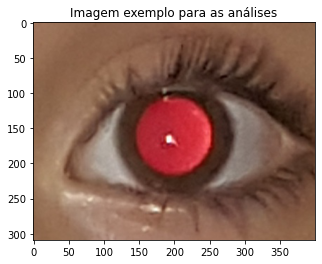

In [2]:
N_I   = "./data/olhos/normal/20170317_151849_1.jpg"

# Ler imagem
image = cv2.imread(N_I)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.title('Imagem exemplo para as análises')
plt.show()

## Primeiro campo de análise: Histogramas de Cor
<hr>
Análise dos Histogramas de Cor para os seguintes Espectros de Cor:
<ul>
    <li>RGB</li>
    <li>HSV</li>
    <li>LAB</li>
</ul>

In [3]:
# Função para plotar gráficos do Histograma
def mostrarGraficos(image, ch_1, ch_2, ch_3):
    f, axarr = plt.subplots(1,2, figsize=(16,4))
    
    axarr[0].imshow(image)
    axarr[1].plot(ch_1, label='CH_1', color='red')
    axarr[1].plot(ch_2, label='CH_2', color='green')
    axarr[1].plot(ch_3, label='CH_3', color='blue')
    axarr[1].legend(loc = 'best')

In [4]:
# Recebe imagem, calcula o hisotgrama de cada canal e plota
def histogramadeCor(image):
    hist = []
    # calcular Histograma de cor para cada canal da imagem
    ch_1 = cv2.calcHist([image], [0], None, [256], [0, 256])
    ch_2 = cv2.calcHist([image], [1], None, [256], [0, 256])
    ch_3 = cv2.calcHist([image], [2], None, [256], [0, 256])
    # mostrar o histograma pra cada canal
    mostrarGraficos(image, ch_1, ch_2, ch_3)
    
    # salva os histogramas em uma variavel
    hist.extend(ch_1)
    hist.extend(ch_2)
    hist.extend(ch_3)
    
    # converte para numpy (pois está em formato de lista)
    hist = np.array(hist)
    
    # retorna um vetor concatenado
    return np.concatenate(hist, axis = 0)

#### RGB (Red, Green, Blue)

In [5]:
# Mostrar as variáveis referentes a imagem nos 3 canais
image_rgb = image
image_rgb[0][0]

array([164, 122,  97], dtype=uint8)

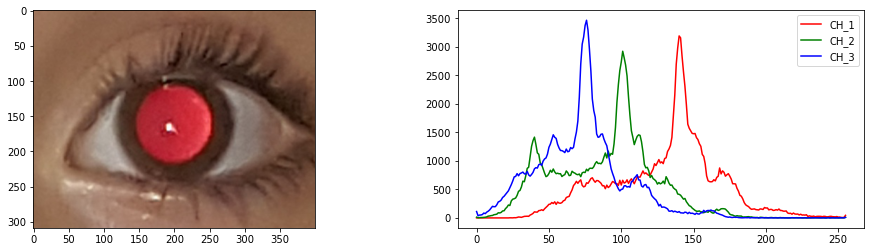

In [6]:
hist_rgb = histogramadeCor(image_rgb)

#### HSV (Hue, Saturation, Value)

In [7]:
image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
image_hsv[0][0]

array([ 11, 104, 164], dtype=uint8)

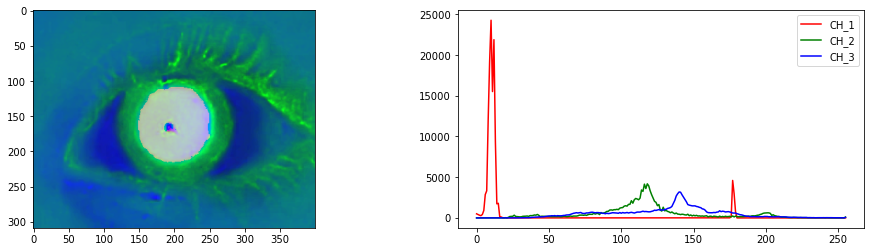

In [8]:
hist_hsv = histogramadeCor(image_hsv)

#### Lab

In [9]:
image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
image_lab[0][0]

array([140, 141, 148], dtype=uint8)

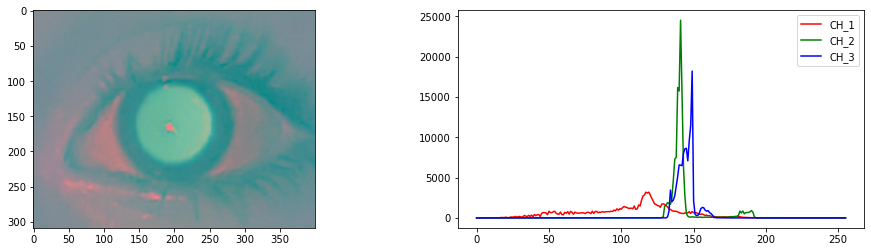

In [10]:
hist_lab = histogramadeCor(image_lab)

#### Representação do Vetor de Características

In [11]:
print(hist_rgb[40:80], type(hist_rgb))

[107. 102. 102. 128. 131. 143. 130. 160. 184. 209. 238. 242. 270. 252.
 282. 237. 278. 260. 257. 269. 300. 310. 357. 369. 378. 439. 490. 567.
 597. 641. 606. 642. 667. 571. 544. 555. 615. 606. 645. 689.] <class 'numpy.ndarray'>


In [39]:
print(hist_rgb[50])

238.0


## Segundo Campo de Análise: HSL com Detecção de Olhos Vermelhos

<hr>
Análise da utilização do HSL com Detecção de Olhos Vermelhos para os seguintes Espectros de Cor:
<ul>
    <li>RGB</li>
</ul>
<b>Só funciona no espectro RGB!</b>

In [12]:
# Recebe uma image, converge para HSL, faz um cálculo e retorna somente
# A parte mais avermelhada da imagem
def hslOlhosVermelhos(img):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    H        = hls[:, :, 0]
    L        = hls[:, :, 1]
    S        = hls[:, :, 2]
    LS_ratio = L/(S + 1e-6)

    # Otimizar?
    redeye = ((L >= 64) * (S >= 90) * np.logical_or(H <= 7, H >= 162) *
              (LS_ratio > 0.5) * (LS_ratio < 1.5)).astype(bool)
    
    redeye = cv2.cvtColor(redeye.astype(np.uint8)*255, cv2.COLOR_GRAY2RGB)
    
    redeye_only = img.copy();
    redeye_only[np.where(np.logical_not(redeye))] = 255
    
    return redeye_only

#### RGB (Red, Green, Blue)

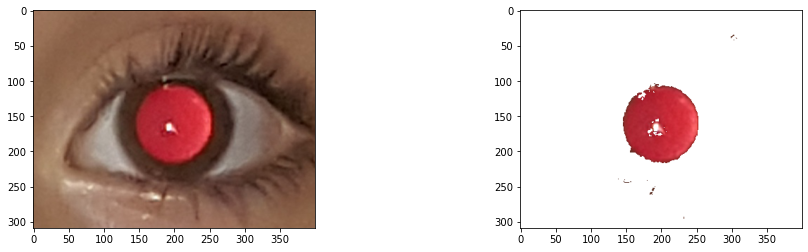

In [13]:
image_OV = hslOlhosVermelhos(image_rgb)

f, axarr = plt.subplots(1,2, figsize=(16,4))
axarr[0].imshow(image)
axarr[1].imshow(image_OV)

#### Representação do Vetor de Características

In [14]:
## Em análise

## Terceiro campo de análise: Descritores de Cor Dominante

<hr>
Análise dos Descritores de Cor Dominante para os seguintes Espectros de Cor:
<ul>
    <li>RGB</li>
    <li>HSV</li>
    <li>LAB</li>
</ul>

<b>Utilizando 4 centróides! (encontrar 4 cores dominantes)</b>

In [15]:
def find_histogram(clt):

    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist

def plot_colors2(hist, centroids):
    
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        # plotar o percentual de cada cluster na imagem
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # retorna o grafico em barra
    return bar

def corDominante(img):

    img = img.reshape((img.shape[0] * img.shape[1],3)) #represent as row*column,channel number
    clt = KMeans(n_clusters = 4) #cluster number
    clt.fit(img)

    hist = find_histogram(clt)
    bar  = plot_colors2(hist, clt.cluster_centers_)
    
    return bar, np.concatenate(clt.cluster_centers_, axis = 0)

#### RGB (Red, Green, Blue)

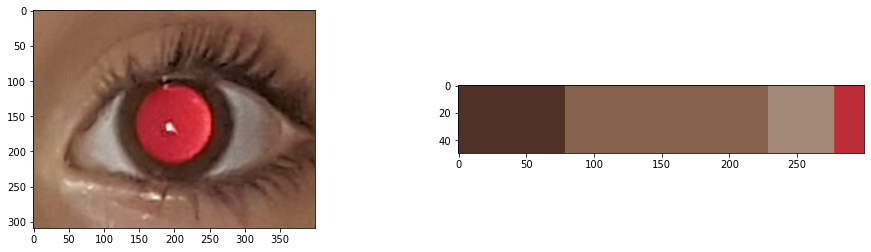

In [16]:
bar_rgb, dominant_rgb = corDominante(image_rgb)

f, axarr = plt.subplots(1,2, figsize=(16,4))
axarr[0].imshow(image_rgb)
axarr[1].imshow(bar_rgb)

#### OBS: TONALIDADE DA PELE AFETA BASTANTE NO VETOR FINAL

#### HSV (Hue, Saturation, Value)

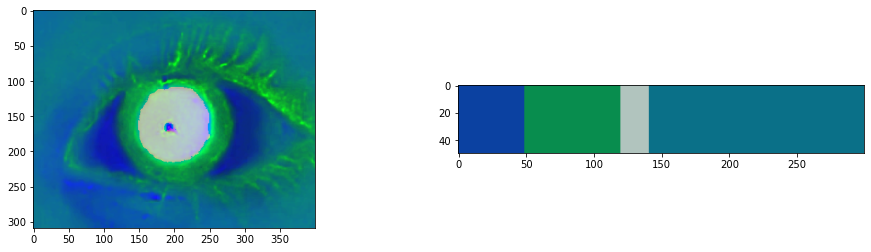

In [17]:
bar_hsv, dominant_hsv = corDominante(image_hsv)

f, axarr = plt.subplots(1,2, figsize=(16,4))
axarr[0].imshow(image_hsv)
axarr[1].imshow(bar_hsv)

#### LAB

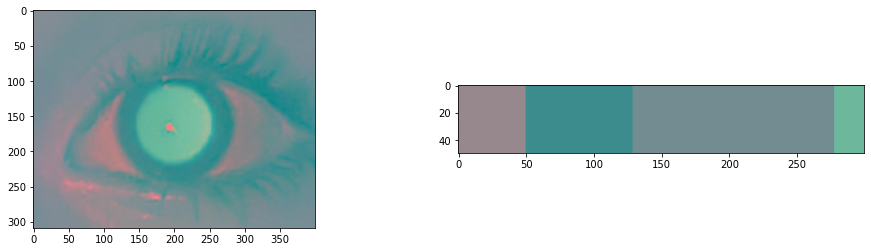

In [18]:
bar_lab, dominant_lab = corDominante(image_lab)

f, axarr = plt.subplots(1,2, figsize=(16,4))
axarr[0].imshow(image_lab)
axarr[1].imshow(bar_lab)

#### Representação do Vetor de Características

In [36]:
print(dominant_rgb, type(dominant_rgb))

[ 80.9044756   49.50329765  37.84272524 135.97167414  98.14366877
  77.09376669 165.91319036 137.38498825 119.56673521 190.36675762
  44.59367894  56.21930423] <class 'numpy.ndarray'>


In [35]:
print(dominant_rgb[0])

80.90447559741169


## Quarto campo de análise: Momentos de Cor
<hr>
Análise dos Momentos de Cor para os seguintes Espectros de Cor:
<ul>
    <li>RGB</li>
    <li>HSV</li>
    <li>LAB</li>
</ul>

In [20]:
def momentosCor(img):
    
    moments = []
    
    # percorre cada canal da imagem
    # e calcula os momentos em cada canal
    for ch in cv2.split(img):
        
        # primeiro momento de cor
        mean      = np.mean(ch)
        moments.append(mean)
        
        # segundo momento de cor
        variance  = np.var(ch)
        moments.append(variance)

        # terceiro momento de cor
        skewness  = skew(ch.reshape(-1))
        moments.append(skewness)
        
        # quarto momento de cor
        kurt      = kurtosis(ch.reshape(-1))
        moments.append(kurt)
    
    return np.array(moments)

In [21]:
moments_rgb = momentosCor(image_rgb)
moments_hsv = momentosCor(image_hsv)
moments_lab = momentosCor(image_lab)

#### Representação do Vetor de Características

In [22]:
print(moments_rgb, type(moments_rgb))

[ 1.30266570e+02  1.37792727e+03 -1.78088495e-01 -1.70868073e-02
  8.79884223e+01  1.16580107e+03  4.41194556e-02 -2.27459832e-01
  7.22742799e+01  8.88126170e+02  4.97918898e-01  1.00100226e+00] <class 'numpy.ndarray'>


In [32]:
print(moments_rgb[0])

130.26656957928802
